In [3]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.1 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 43.2 MB/s eta 0:00:01
     |████████████████████████████████| 30.3 MB 7.6 MB/s eta 0:00:011
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn xgboost

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.9 MB 4.4 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


- Since XGBoost was having errors, I decided to use CatBoost. 
- CatBoost is particularly well-suited for this dataset. 
- It reduces preprocessing effort, handles categorical variables intelligently, and delivers strong predictive performance on small-to-medium structured data like a sales pipeline.

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 8.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/var/folders/zv/ft654ndd6nb8khhg3y2nqnth0000gn/T/ipykernel_55616/2025539329.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/var/folders/zv/ft654ndd6nb8khhg3y2nqnth0000gn/T/ipykernel_55616/2025539329.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/var/folders/zv/ft654ndd6nb8khhg3y2nqnth0000gn/T/ipykernel_55616/2025539329.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

0:	learn: 0.9896307	test: 0.9875000	best: 0.9875000 (0)	total: 30.8ms	remaining: 15.4s
100:	learn: 0.9955966	test: 0.9943182	best: 0.9943182 (48)	total: 1.65s	remaining: 6.53s
200:	learn: 0.9957386	test: 0.9943182	best: 0.9943182 (48)	total: 3.4s	remaining: 5.05s
300:	learn: 0.9961648	test: 0.9943182	best: 0.9943182 (48)	total: 4.91s	remaining: 3.24s
400:	learn: 0.9963068	test: 0.9943182	best: 0.9943182 (48)	total: 6.37s	remaining: 1.57s
499:	learn: 0.9965909	test: 0.9943182	best: 0.9943182 (48)	total: 7.73s	remaining: 0us

bestTest = 0.9943181818
bestIteration = 48

Shrink model to first 49 iterations.

Accuracy: 0.9943181818181818

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       318
           1       1.00      1.00      1.00       494
           2       0.92      1.00      0.96       100
           3       1.00      1.00      1.00       848

    accuracy                           0.99      1760
   macro

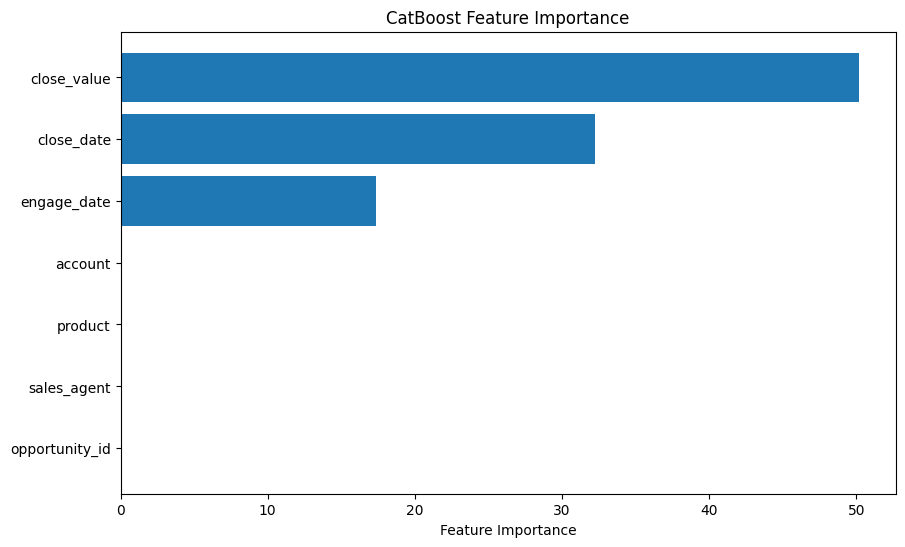

In [10]:
# ----------------------------
# Boosted Trees with CatBoost
# ----------------------------
import pandas as pd
from catboost import CatBoostClassifier, Pool # special data structure to handle categorical features efficiently
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # converts categorical labels into numbers
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# ----------------------------
# Load cleaned datasets
# ----------------------------
sales_pipeline = pd.read_csv("data_cleaned/cleaned_sales_pipeline.csv")
accounts = pd.read_csv("data_cleaned/cleaned_accounts.csv")
products = pd.read_csv("data_cleaned/cleaned_products.csv")
sales_teams = pd.read_csv("data_cleaned/cleaned_sales_teams.csv")

# ----------------------------
# Prepare Features and Target
# ----------------------------
target_column = 'deal_stage' # predicts won/lost based on other features
feature_columns = [col for col in sales_pipeline.columns if col != target_column]

# sales_pipeline is the main dataset, others can be used for feature engineering
X = sales_pipeline[feature_columns]
y = sales_pipeline[target_column]

# encode categorical features and target
cat_features = X.select_dtypes(include='object').columns.tolist()
for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# encode target if categorical
# if target(deal_stage) is won/lost strings, encode to 0/1 
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------
# Train CatBoost Classifier
# ----------------------------
model = CatBoostClassifier(
    iterations=500, # of boosting rounds (trees)
    learning_rate=0.05, # size of each iteration; smaller value; slower but more accurate
    depth=6, # max depth of each tree; controls model complexity
    eval_metric='Accuracy', # metric used to evaluate performance on validation set
    verbose=100, # prints training progress every 100 iterations
    random_seed=42 # ensures reproducible results
)

# CatBoost can handle categorical features via Pool
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# fit model
model.fit(train_pool, eval_set=test_pool)

# ----------------------------
# Evaluate Model
# ----------------------------
y_pred = model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ----------------------------
# Feature Importance
# ----------------------------
feature_importances = model.get_feature_importance(train_pool)
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()


1. Categorical features with near-zero importance
   - account, product, sales_agent, opportunity_id being nearly zero means the model didn't find these features useful for predicting deal_stage.
2. Numeric/date features with high importance
   - close_value, close_date, engage_date having high importance means the  model relies heavily on them for predictions.
   - the model is detecting patterns in numeric/date features that explain the target better than categorical identifiers. 
3. Implications
   - dropping uninformative IDs like opportunity_id, which will not help the model but may add noise.

Overall, this graph indicates the model finds numeric/date features predictive, while raw categorical identifiers mostly do not contribute.